In [1]:
# Imports
import PySimpleGUI as sg
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import os
import scipy
import numpy as np
from PIL import Image, ImageTk
import random
import json 
import metrics



In [2]:
musc_dict_flipped = {value: key for key, value in muscle_dict.items()}
musc_dict_flipped[11]

NameError: name 'muscle_dict' is not defined

In [3]:
# Grab working directory
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)

# Load Object Dict (Object # ID: Object Name)
with open('object_dict.json', mode='r') as f:
    object_dict = json.load(f)

# Flip Dict (Object Name: Object # ID)
object_dict_flipped = {value: key for key, value in object_dict.items()}


# Muscle list for dropdown menu TODO: All muscles indexing is wrong 
muscle_list = ['All Muscles', 'DELT1', 'DELT2', 'DELT3', 'SUPRA', 'INFRA', 'SUBSCAP', 'TMIN', 'TMAJ',
               'PMAJ1', 'PMAJ2', 'PMAJ3', 'LAT1', 'LAT2', 'LAT3', 'CORB', 'TRIlong', 'TRIllat', 'TRIlmat', 
               'ANC', 'SUP', 'BIClong', 'BICshort', 'BRA', 'BRD', 'ECRL', 'ECRB', 'ECU', 'FCR', 'FCU', 
               'PL', 'PT', 'PQ', 'FDSL', 'FDSR', 'FDSM', 'FDSI', 'FDPL', 'FDPR', 'FDPM', 'FDPI',
               'EDCL','EDCR', 'EDCM', 'EDCI', 'EDM', 'EIP', 'EPL', 'EPB', 'FPL', 'APL']

# Create dictionary from muscle list 
muscle_dict = {muscle: index - 1 for index, muscle in enumerate(muscle_list)}

# Delete objects with no output associated (usually no pic for >=7 objects and no data for <7)
delete_objs = ['cube4', 'hcyl3', 'hcyl7', 'box1', 'box7', 'ring5', 'ring7', 'sphere1', 'sphere5', 'sphere7', 'sphere8', 'cube7']
for obj in delete_objs:
    del object_dict_flipped[obj]

# Convert to lists for GUI dropdowns 
t_list = list(object_dict_flipped.keys())
object_list = list(object_dict_flipped.keys())


brady_file_path = os.path.join(parent_directory, 'metrics', 'bradykinesia.npz')
brady = np.load(brady_file_path)

hypo_file_path = os.path.join(parent_directory, 'metrics', 'hypokinesia.npz')
hypo = np.load(hypo_file_path)

akin_file_path = os.path.join(parent_directory, 'metrics', 'akinesia.npz')
akin = np.load(akin_file_path)

trem_file_path = os.path.join(parent_directory, 'metrics', 'tremor_factor.npz')
trem = np.load(trem_file_path)


In [4]:
# Given an object name, find the first trial that corresponds to that object
    #TODO: Change to averaged across all trials of the same object 
def find_trial_from_object(object_idxs, object_name):
    object_id = object_dict_flipped.get(object_name)
    indexes = np.where(object_idxs == int(object_id))
    if (len(indexes)) == 0: 
        print("Object not found. Please select a different object.")
        #idk do something??   
        # Note: indexes[0] gives array, indexes[0][0] gives first item in array 
    first_trial_object = int(indexes[0][0])
    trial_hold_data = hold_data[first_trial_object]
    inxs = np.argwhere(trial_hold_data<1)
    go_cue = inxs[0]
    try:
        exp_data = mat_data['targ'][0][int(indexes[0][0])]
        exp_data = pd.DataFrame(exp_data, index = muscle_list[1:])
        model_data = mvm_data_full[int(indexes[0][0])]
        ext_inf_data = ext_inf_full[int(indexes[0][0])]
    except: 
        print("Object not found in list")
        zero_data = np.zeros(shape=(100, 100))
        d = pd.DataFrame(zero_data)
        return d, d
    return exp_data, model_data, first_trial_object, go_cue, ext_inf_data


def plot_data(output_data, muscle, expt_data, go_cue, ext_inf_data = None):
    if muscle_dict[muscle] > -1:
        output_data = output_data[:, muscle_dict[muscle]]
        min_y = min(output_data)
    else: 
        # TODO: Figure out what to do here. We want to prevent the user from selecting All Muscles *while* expt_data is already selected
        # (and therefore a single muscle was already selected). How/Should we go back to the single muscle or should we deselect the expt_data
        # if expt_data:
        #     print("Cannot display expt data against All Muscles. Please select a different muscle and try again")
        #     pass    
        output_data = output_data
        min_y = min(output_data[:, 0])
    # output_data = output_data[220:]
    output_data.tolist()
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(output_data, label = "Output Data")
    ax.axvline(x=go_cue, color='r', linestyle='--')
    ax.annotate('  Go Cue', xy=(go_cue, min_y), # xytext=(2.6, 0.2),
                fontsize=10, ha='left')
    if muscle is not "All Muscles" and expt_data:
        expt_data_plot = mvm_data_expt.loc[muscle]
        # expt_data_plot = expt_data_plot[220:298]
        ax.plot(expt_data_plot, label = "Expt Data")
    if ext_inf_data is not None: 
        ext_inf_data_plot = ext_inf_data[:, muscle_dict[muscle]]
        # ext_inf_data_plot = ext_inf_data
        ax.plot(ext_inf_data_plot, label = "External Influence")
    ax.set_xlabel('Time')
    ax.set_ylabel('Muscle Velocity')
    ax.set_title(muscle)
    ax.set_xlim(left = 220)
    if muscle_dict[muscle] > -1: # im so sorry code quality 
        plt.legend()
    return fig

# Function to find muscle_image
def muscle_image(muscle_name):
    if muscle_name is None:
        muscle_name = 'DELT1'
    muscle_file_path = os.path.join(muscle_folder_path, muscle_name + '.png')
    size = (450, 150)
    im = Image.open(muscle_file_path)
    # im = im.crop((102,202,1002,502))
    # cropped = im.crop((0, 0, 200, 200))
    # tk_im = ImageTk.PhotoImage(cropped)
    im = im.resize(size, resample=Image.BICUBIC)
    return ImageTk.PhotoImage(image = im)

# Function to find muscle_image
def object_image(object_name):
    object_file_path = os.path.join(object_folder_path, object_name + '.png')
    print(object_file_path)
    size = (150, 150)
    im = Image.open(object_file_path)
    im = im.resize(size, resample=Image.BICUBIC)
    return ImageTk.PhotoImage(image = im)


<>:46: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
<>:46: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
/var/folders/vl/h_05p4l17bjbvfhgqzccm8dw0000gn/T/ipykernel_48003/3184952505.py:46: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if muscle is not "All Muscles" and expt_data:


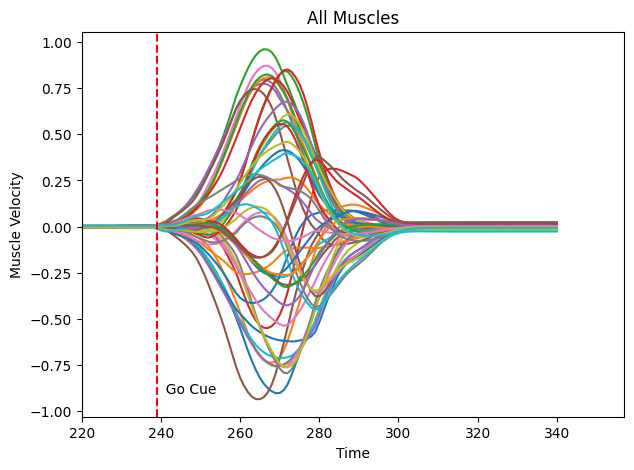

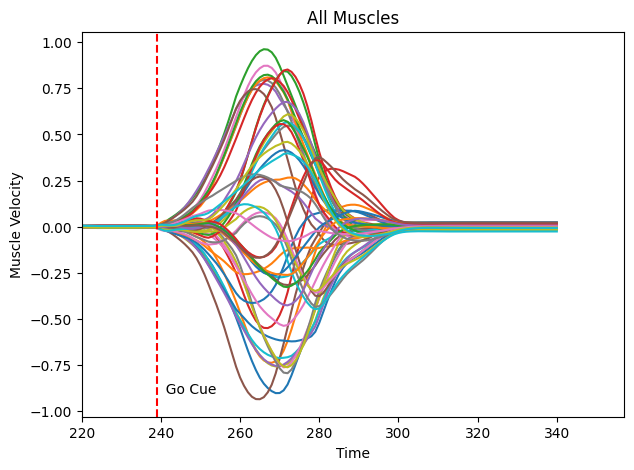

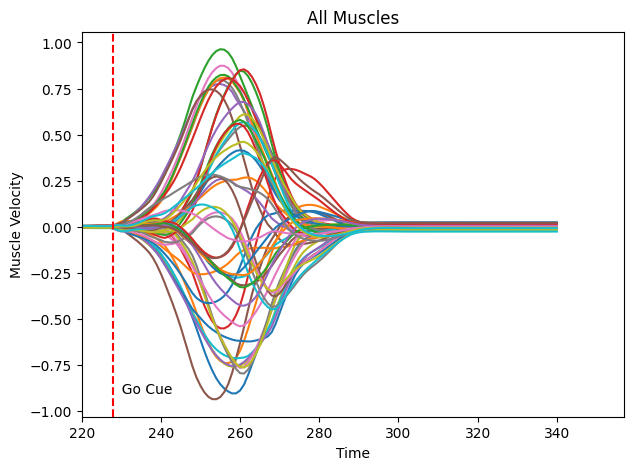

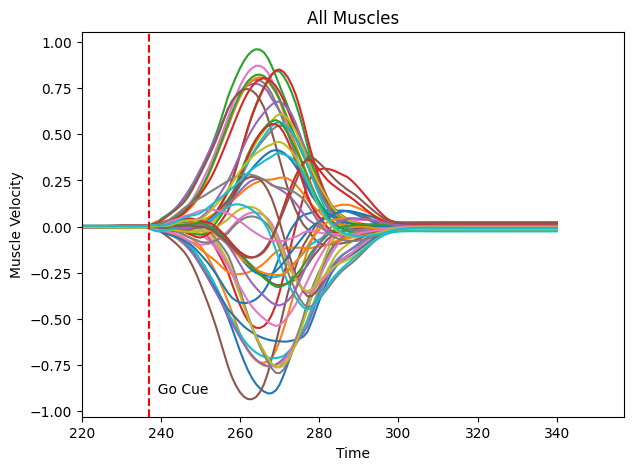

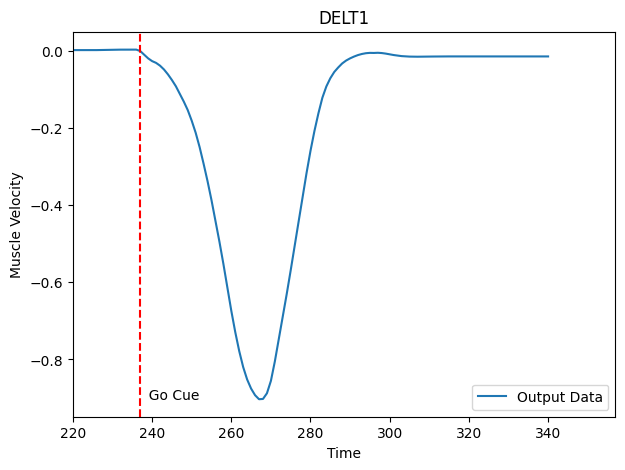

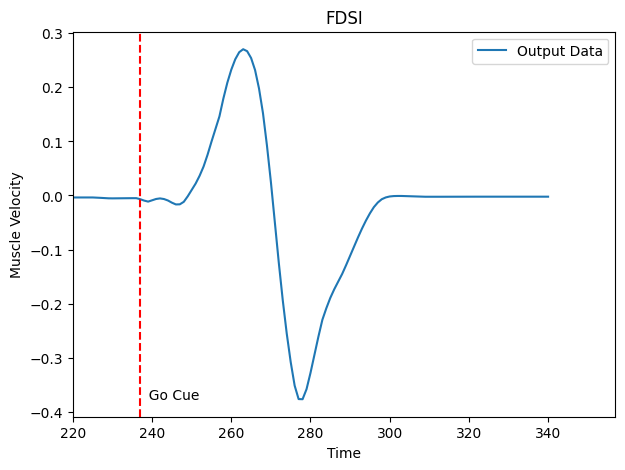

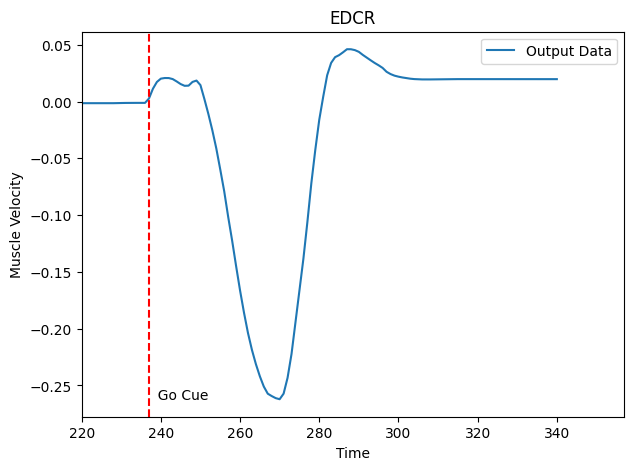

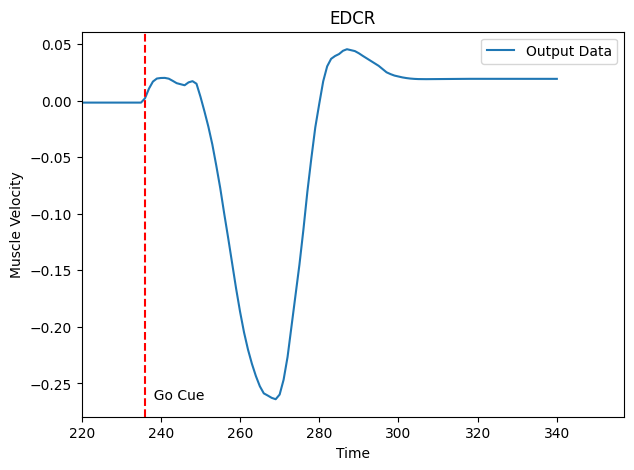

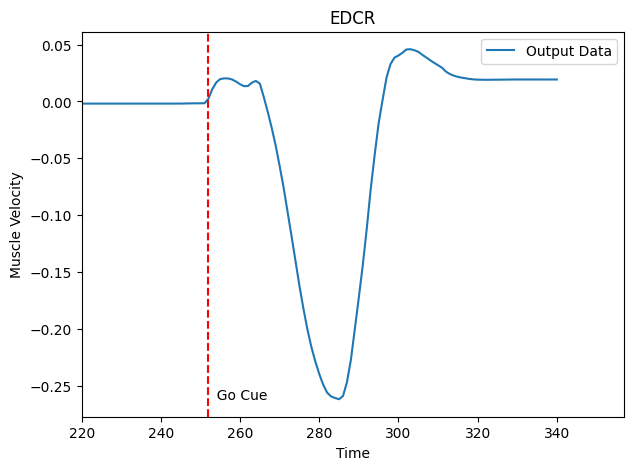

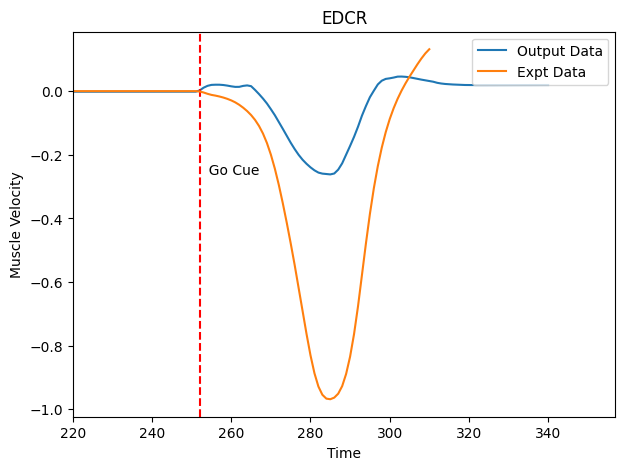

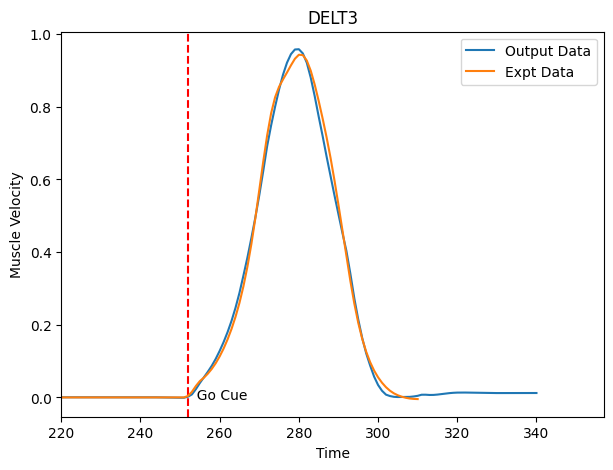

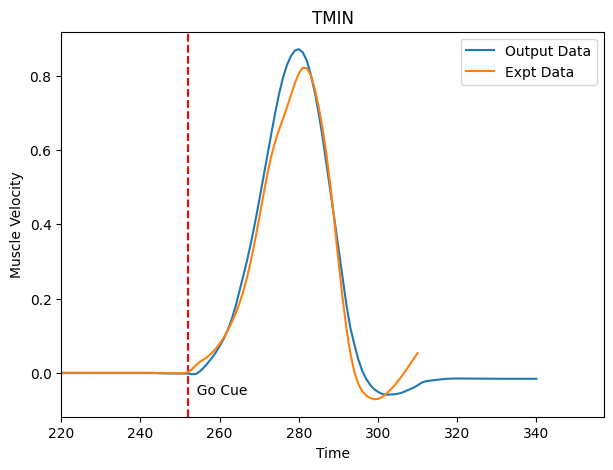

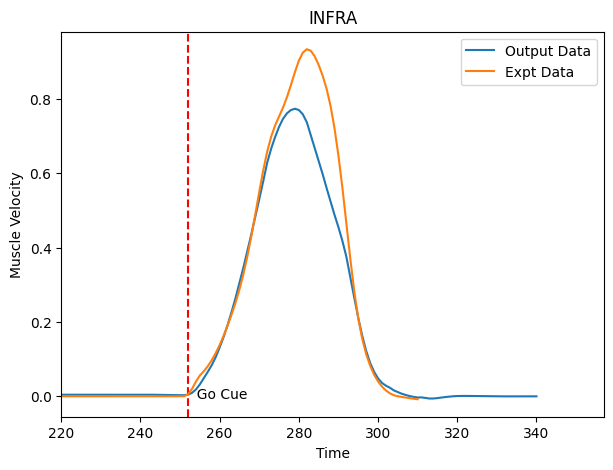

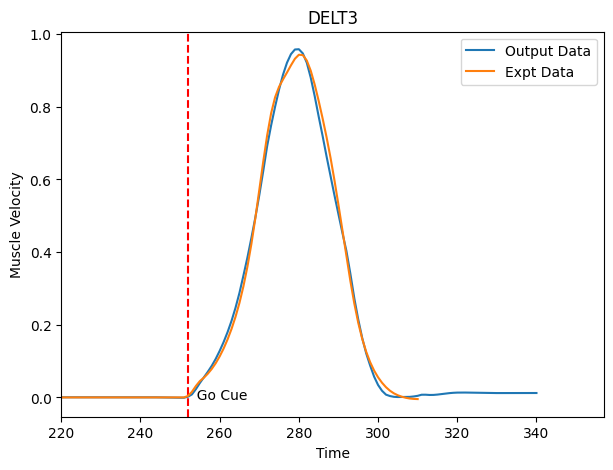

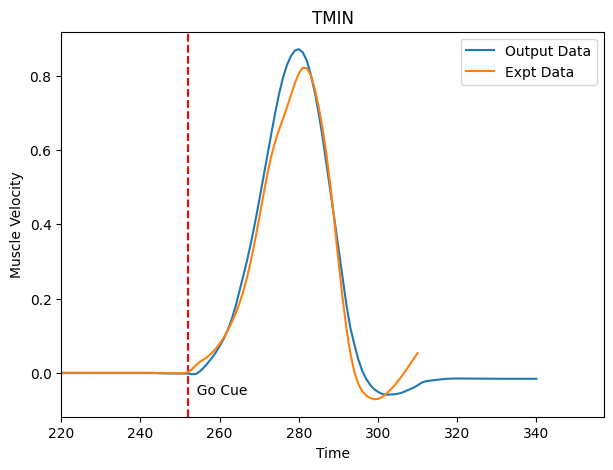

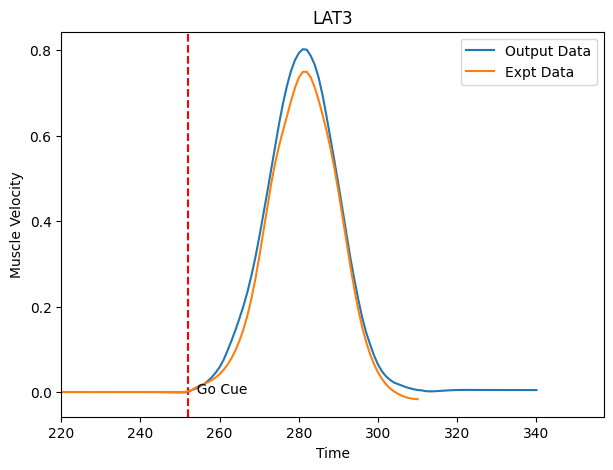

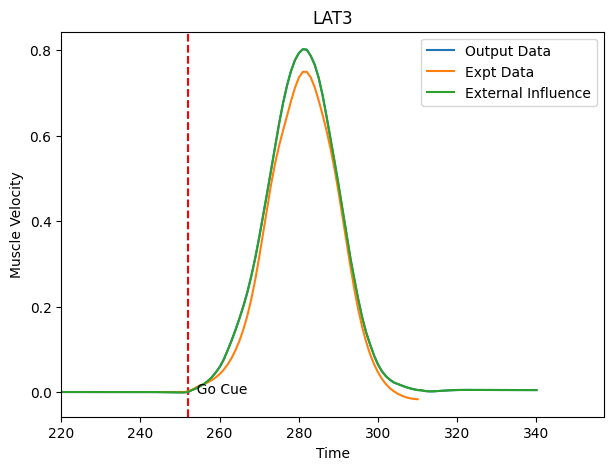

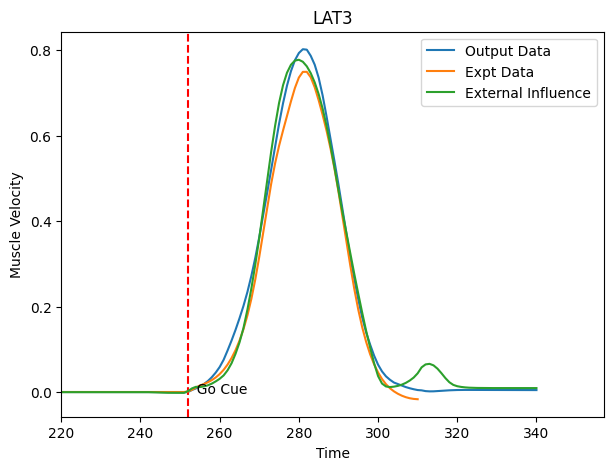

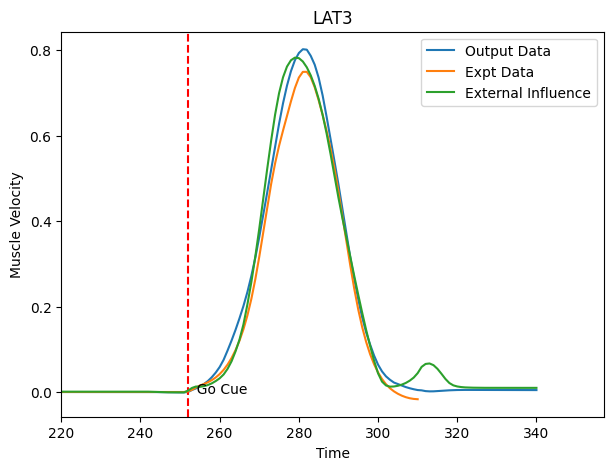

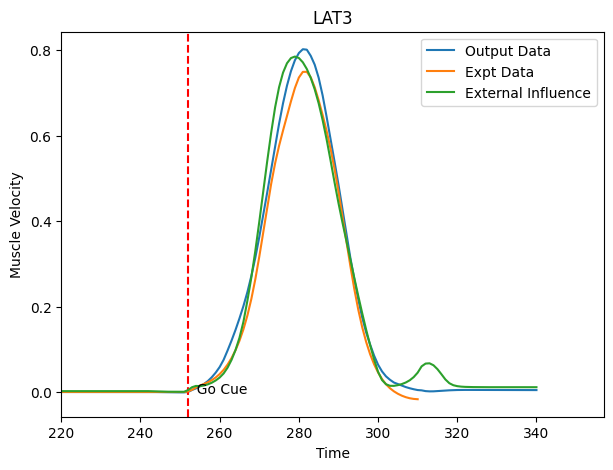

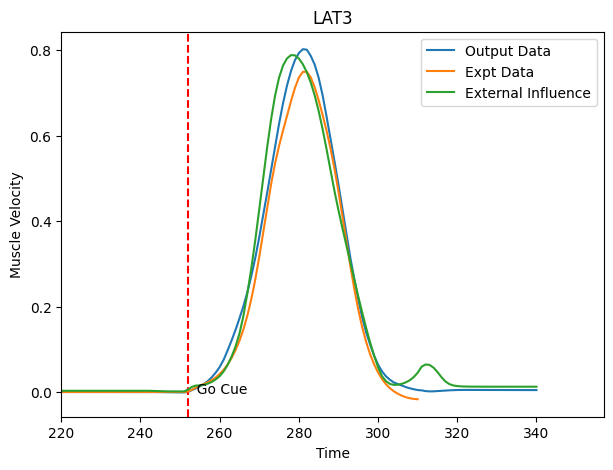

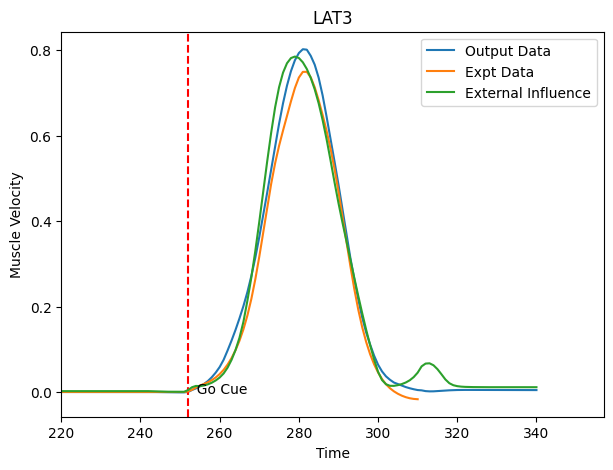

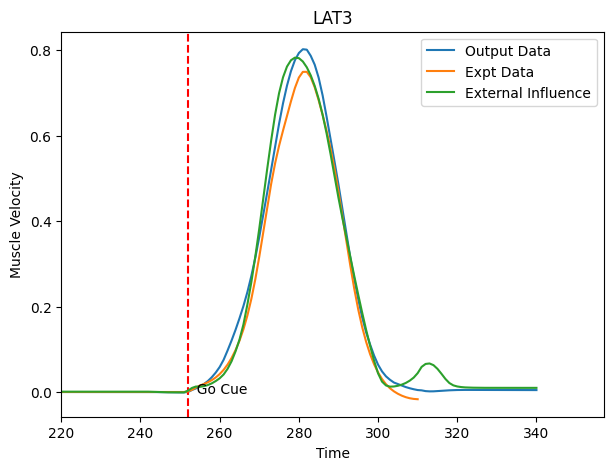

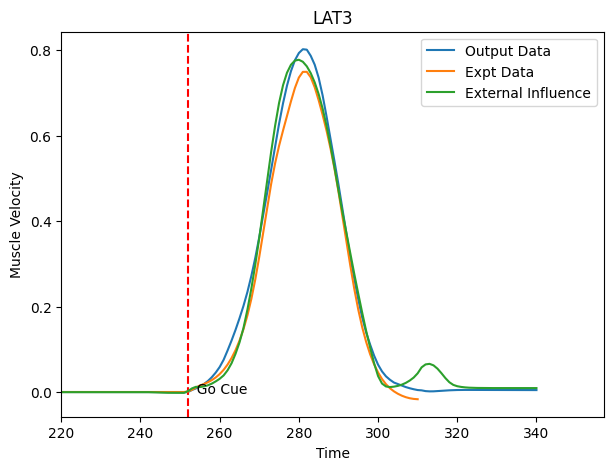

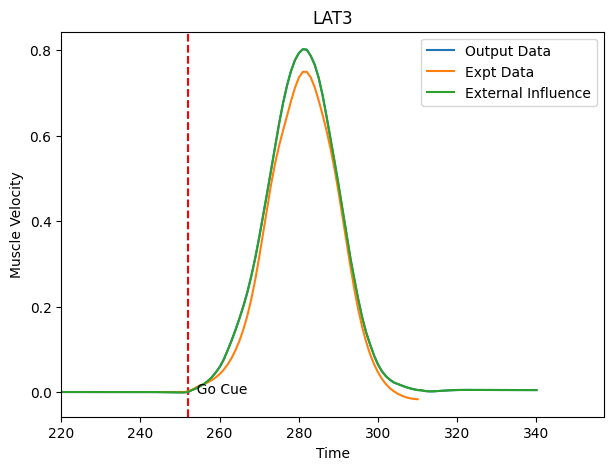

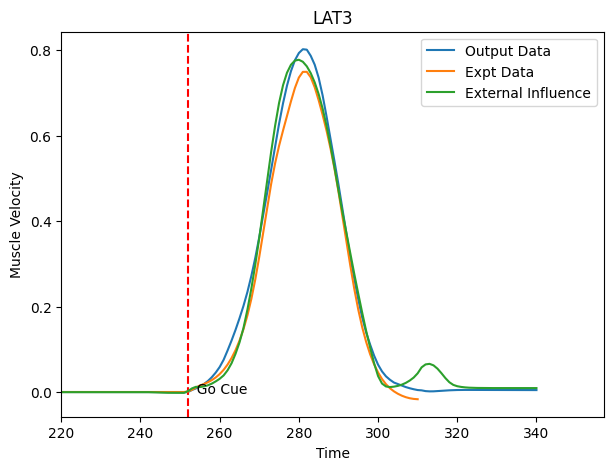

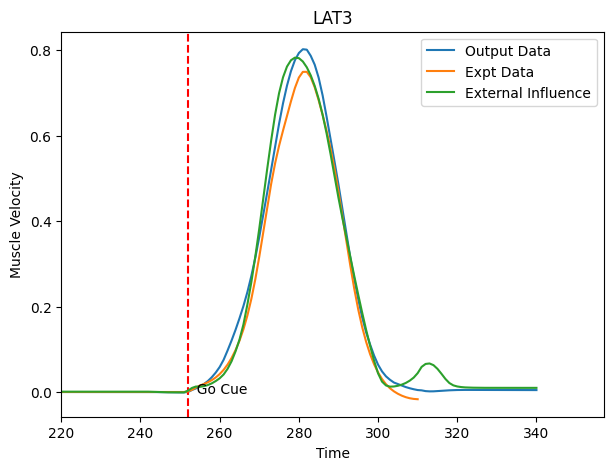

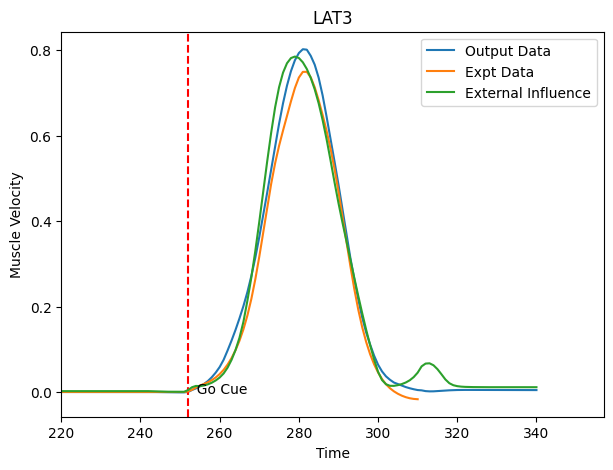

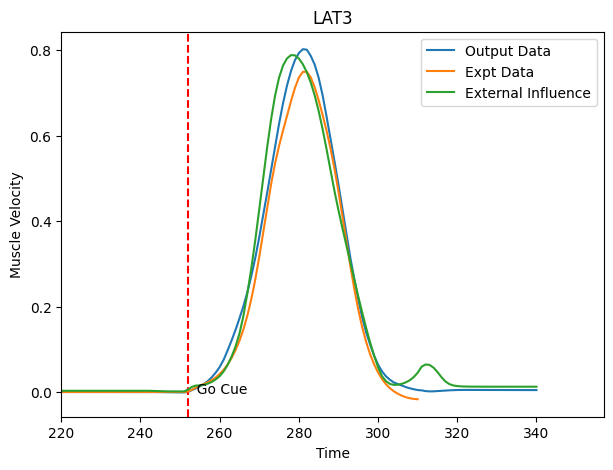

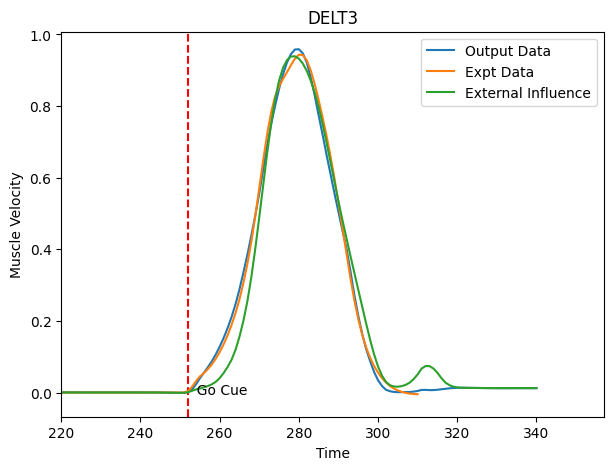

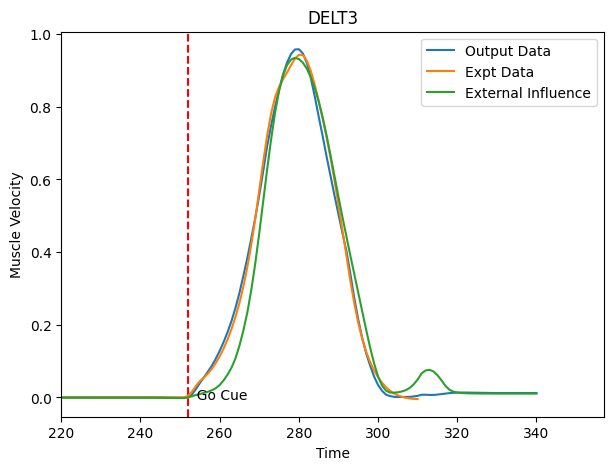

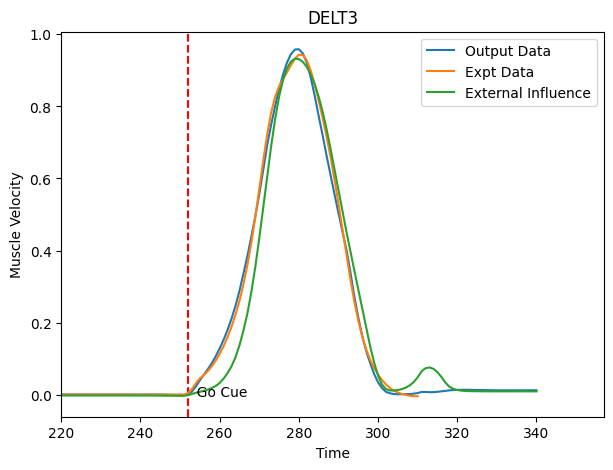

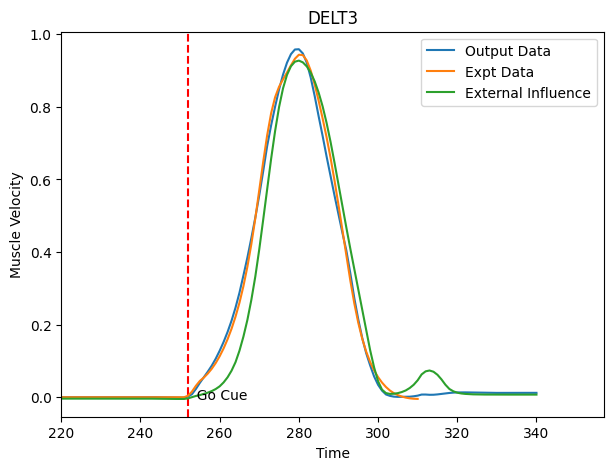

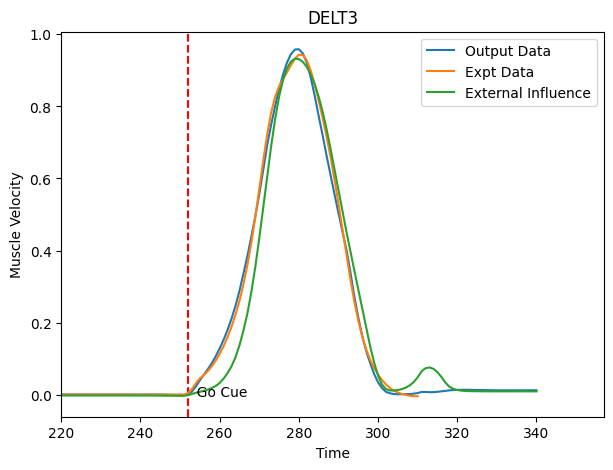

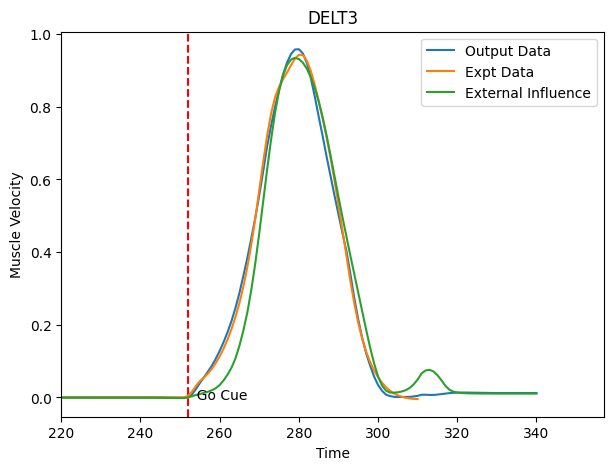

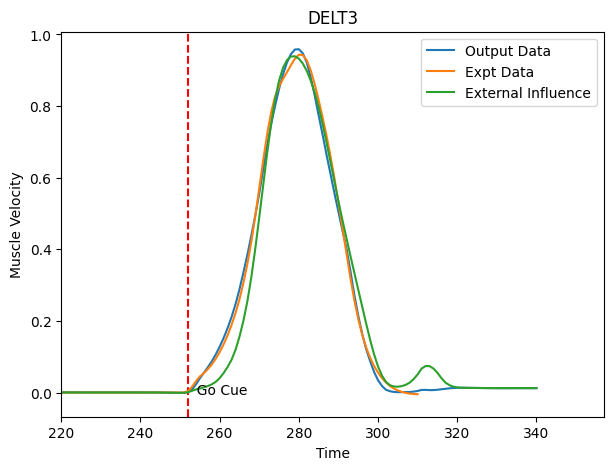

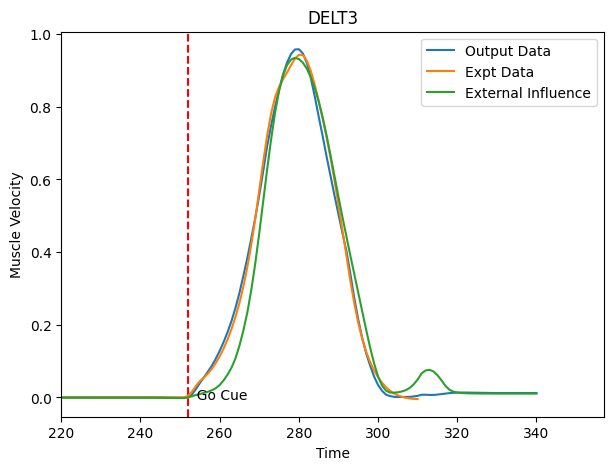

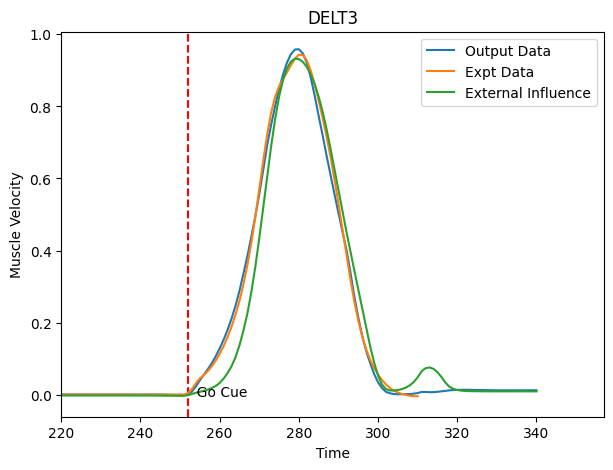

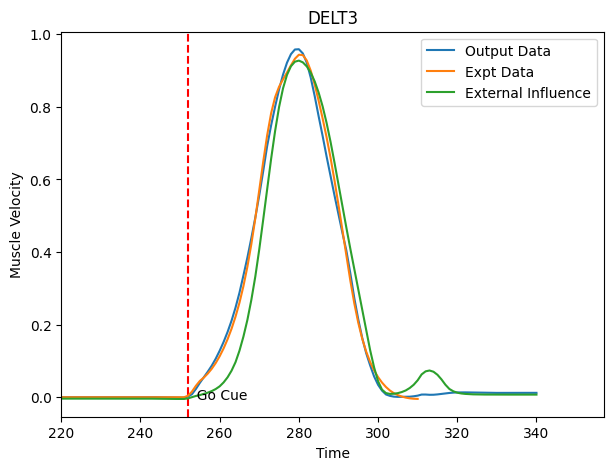

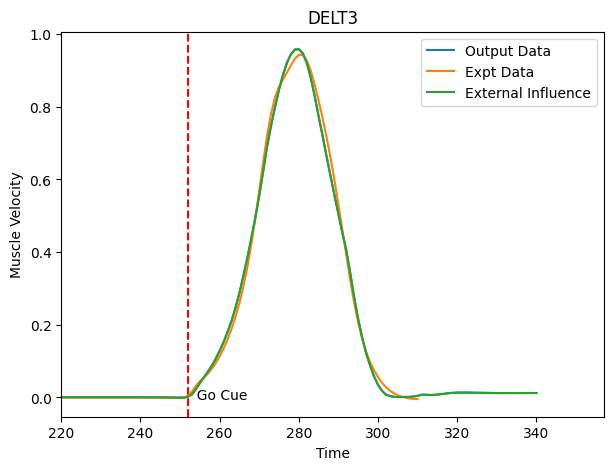

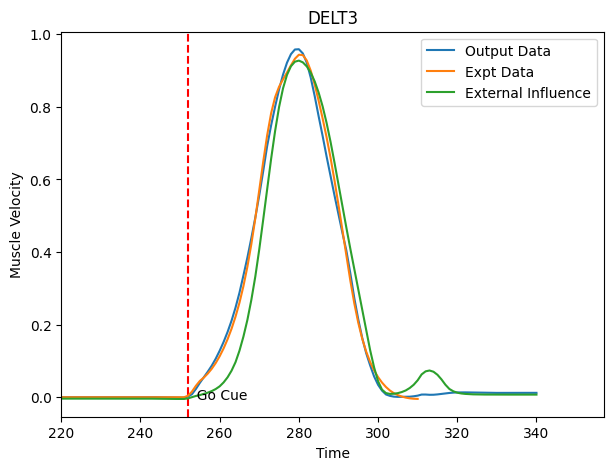

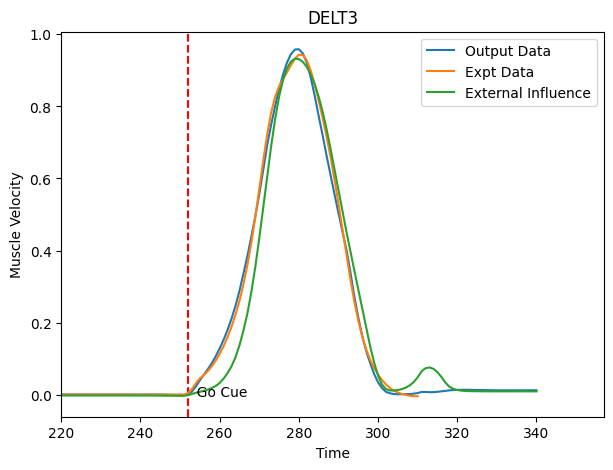

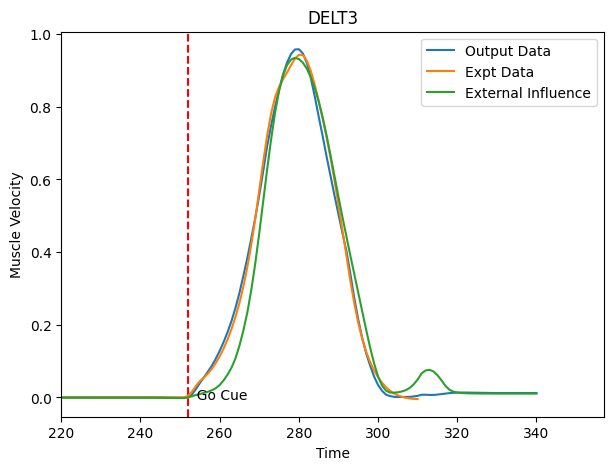

In [5]:
# Get relative path of gui file
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)

# "Experimental Data" TODO: Which trial to use? Some kind of average? How to account for differing hold signals?
exp_file_path = os.path.join(parent_directory, "model", "monkey_data.mat")
mat_data = scipy.io.loadmat(exp_file_path)
object_idxs = mat_data['trialInfo'][:,0]

output_file_path = os.path.join(parent_directory, 'model_outputs', 'TESTTHESE_backpad_longrun.pickle')
mvm_data_full = pd.read_pickle(output_file_path)

# data_0_path = output_file_path
# data_25_path = os.path.join(parent_directory, 'model_outputs', 'TESTTHESE.pickle')
# data_50_path = os.path.join(parent_directory, 'model_outputs', 'TESTTHESE_backpad.pickle')
# data_75_path = os.path.join(parent_directory, 'model_outputs', 'generated_outputs_new.pkl')
# data_100_path = os.path.join(parent_directory, 'model_outputs', 'test_outputs.pickle')
ext_inf_full = pd.read_pickle(output_file_path)


mvm_met_exp = mat_data['targ']
mvm_met_test = np.load(output_file_path, allow_pickle=True)
inp_data = mat_data['inp']
for ind,trash in enumerate(inp_data[0]):
    inp_data[0][ind] = inp_data[0][ind][20]
hold_data = inp_data[0]
# sophie change: this was pointing to an old image i think so i just changed the dir
object_folder_path = os.path.join(parent_directory, 'objects/old')
mvm_data_expt, mvm_data, trial_num, go_cue, ext_inf_data= find_trial_from_object(object_idxs, 'abs1')

# SOPHIE CHANGE: I DON'T KNOW WHERE TO PUT THESE, THEY NEED TO CHANGE BASED ON MODEL, BUT TAKE TOO LONG
#       TO BE COMPUTED FOR EVERY REFRESH
# ground_brady_full, model_brady_full, p_val_brady = metrics.bradykinesia(mvm_met_test, mvm_met_exp[0])
# ground_hypo_full, model_hypo_full, p_val_hypo = metrics.hypokinesia(mvm_met_test, mvm_met_exp[0])
# ground_akin_full, model_akin_full, p_val_akin = metrics.akinesia(mvm_met_test, mvm_met_exp[0], hold_data, hold_data)
# ground_trem_full, model_trem_full, p_val_trem = metrics.tremor_factor(mvm_met_test, mvm_met_exp[0])

# For plotting x-axis
time_axis = np.arange(2.2, 2.98, .01)

muscle_folder_path = os.path.join(parent_directory, 'muscles')
object_folder_path = os.path.join(parent_directory, 'objects')

# GUI Layout
left_column = [
    [sg.Canvas(size=(640, 480), key='-CANVAS-')],
    [
        # sg.Column([
        # [sg.Combo(object_list, key = '-OBJECTS-', default_value = 'abs1', enable_events=True, size=(10, 20))],
        # [sg.Combo(muscle_list, key = '-MUSCLES-', default_value = 'All Muscles', enable_events=True, size=(10, 20))]
        #     ]),
    sg.Image(size=(300, 200), key='-MUSCLE_IMAGE-'), sg.Image(size = (50, 50), key = "-OBJECT_IMAGE-")]
]

muscle_choice = [
    [sg.Text("Show All/Single Muscle", justification='right', font=('Helvetica', 10, 'bold'))], 
    [sg.Checkbox("All Muscles", key = "all_musc", enable_events= True, font=('Helvetica', 10, 'bold'), default = True)],
    [sg.Checkbox("'Single Muscle'", key = "single_musc", enable_events= True, font=('Helvetica', 10, 'bold'), disabled = True), sg.Combo(muscle_list[1:], key = '-MUSCLES-', default_value = 'DELT1', enable_events=True, size=(10, 20), disabled = True)],
]



metrics_define = [
        [sg.Text('')],
        [sg.Text('BradyKinesia Measurement')],
        [sg.Text('Hypokinesia Measurement')],
        [sg.Text('Akinesia Measurement')],
        [sg.Text('Tremor Factor')]
    ]
metrics_ground = [
        [sg.Text('Ground')],
        [sg.Text('0', key = 'ground_brady')],
        [sg.Text('0', key = 'ground_hypo')],
        [sg.Text('0', key = 'ground_akin')],
        [sg.Text('0', key = 'ground_tremor')]
    ]
metrics_model = [
        [sg.Text('Model')],
        [sg.Text('0', key = 'model_brady')],
        [sg.Text('0', key = 'model_hypo')],
        [sg.Text('0', key = 'model_akin')],
        [sg.Text('0', key = 'model_tremor')]
    ]
metrics_compare = [
        [sg.Text('Compare')],
        [sg.Text('0', key = 'compare_brady')],
        [sg.Text('0', key = 'compare_hypo')],
        [sg.Text('0', key = 'compare_akin')],
        [sg.Text('0', key = 'compare_tremor')]
    ]
# For slider tick marks
right_column = [
    [sg.HSeparator()],
    [sg.Text('External Influence on the Model', justification='center', font=('Helvetica', 16, 'bold'))],  # TODO: NOT FUNCTIONAL
    [sg.Slider(range=(0,100), orientation='h', resolution=25, size=(30, 20), default_value=0, key='-SLIDER-', enable_events=True, expand_x=True, tick_interval=25)],
    [sg.HSeparator()], 
    [sg.Column([[sg.Text("Change Object", justification='right', font=('Helvetica', 10, 'bold'))], [sg.Combo(object_list, key = '-OBJECTS-', default_value = 'abs1', enable_events=True, size=(10, 20))]]), sg.VSeparator(), sg.Column(muscle_choice), sg.VSeparator(), sg.Column([[sg.Text("Show Other Data/Models", justification='right', font=('Helvetica', 10, 'bold'))], [sg.Checkbox("Add Experimental Data", key = "expt", enable_events= True, disabled = True)], [sg.Checkbox('Add External Influence', key = 'ext_inf', enable_events = True, disabled = True)]])],
    [sg.HSeparator()],
    [sg.Text('Metrics', justification='center', font=('Helvetica', 16, 'bold'))], # TODO: CURRENTLY RANDOM
    [sg.Column(metrics_define), sg.VSeparator(), sg.Column(metrics_ground), sg.VSeparator(), sg.Column(metrics_model), sg.VSeparator(), sg.Column(metrics_compare)],
    [sg.HSeparator()],
    [sg.Text('Console Output:',justification='center', font=('Helvetica', 16, 'bold'))],
    [sg.Output(size = (70, 5))],
]

# Final Layout
layout = [ [[sg.Text("Neuro Engineering Capstone", font='Any 20 bold')]],
    [sg.Column(left_column), sg.VSeperator(), sg.Column(right_column)], 
]
# Create the GUI window
window = sg.Window('DataFrame Plotter', layout, finalize = True)

# Initialize canvas and fig
canvas_elem = window['-CANVAS-']
fig = plot_data(mvm_data, "All Muscles", False, go_cue)
canvas = None
o_image = None
m_image = None

canvas = FigureCanvasTkAgg(fig, canvas_elem.TKCanvas)
canvas.draw()
canvas.get_tk_widget().pack(side='top', fill='both', expand=1)
m_image = muscle_image('All Muscles')
window['-MUSCLE_IMAGE-'].update(data=m_image)
o_image = object_image('abs1')
window['-OBJECT_IMAGE-'].update(data=o_image)

# Event loop
while True:
    event, values = window.read()
    # if just_opened:
    #     just_opened = False
    #     fig = plot_data(mvm_data, "All Muscles", values['expt'])
    if event == sg.WINDOW_CLOSED or event == 'Exit':
        if fig is not None:
            plt.close(fig)  # Close the figure to prevent it from being printed
        break
    elif event == 'expt':
        muscle_name = values['-MUSCLES-']
        if muscle_name == "All Muscles":
            window['expt'].update(False)
            print("Cannot display expt data against All Muscles. Please select a different muscle and try again")
            continue
        else:
            fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue)
    
    
    elif event == 'ext_inf':
        if values['ext_inf']:
            ext_inf_path = 'data_' + str(round(values['-SLIDER-']))
            ext_inf_full = pd.read_pickle(os.path.join(parent_directory, 'model_outputs',ext_inf_path + '.pickle'))
            mvm_data_expt, mvm_data, first_trial_object, go_cue, ext_inf_data = find_trial_from_object(object_idxs, values['-OBJECTS-'])

            fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue, ext_inf_data)
        else:
            fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue)
    
    elif event == "-SLIDER-":
        if values['ext_inf']:
            ext_inf_path = 'data_' + str(round(values['-SLIDER-']))
            ext_inf_full = pd.read_pickle(os.path.join(parent_directory, 'model_outputs',ext_inf_path + '.pickle'))
            mvm_data_expt, mvm_data, first_trial_object, go_cue, ext_inf_data = find_trial_from_object(object_idxs, values['-OBJECTS-'])

            fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue, ext_inf_data)
    
    elif event == "-OBJECTS-":
        o_image = object_image(values['-OBJECTS-'])
        window['-OBJECT_IMAGE-'].update(data=o_image)
        mvm_data_expt, mvm_data, first_trial_object, go_cue, ext_inf_data = find_trial_from_object(object_idxs, values['-OBJECTS-'])
        if values['single_musc']:
            fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue)
            
        else:
            fig = plot_data(mvm_data, 'All Muscles', values['expt'], go_cue)

        # ground_brady_full, model_brady_full, p_val_brady = metrics.bradykinesia(mvm_met_test, mvm_met_exp[first_trial_object])
        # ground_hypo_full, model_hypo_full, p_val_hypo = metrics.hypokinesia(mvm_met_test, mvm_met_exp[first_trial_object])
        # ground_akin_full, model_akin_full, p_val_akin = metrics.akinesia(mvm_met_test, mvm_met_exp[first_trial_object], hold_data, hold_data)
        # ground_trem_full, model_trem_full, p_val_trem = metrics.tremor_factor(mvm_met_test, mvm_met_exp[first_trial_object])

        # Search through output data to find selected object ID trial (trial information)
        # Set data = output data
        # right now only done for mvm_data_expt, need to do for model output
        # TODO: Need to keep object information with the model output info 
    elif event == 'all_musc': 
        if not values['all_musc']:
            window['single_musc'].update(disabled = False)
        else: 
            window['expt'].update(False)
            window['ext_inf'].update(False)
            if o_image is None:
                o_image = object_image(values['-OBJECTS-'])
                window['-OBJECT_IMAGE-'].update(data=o_image)
            window['expt'].update(disabled = True)
            window['single_musc'].update(disabled = True)
            window['ext_inf'].update(disabled = True)
            m_image = muscle_image('All Muscles')
            window['-MUSCLE_IMAGE-'].update(data=m_image)
            fig = plot_data(mvm_data, 'All Muscles', values['expt'], go_cue)
            ground_brady = round(brady['ground'][muscle_dict[muscle_name]], 4)
            model_brady = round(brady['model'][muscle_dict[muscle_name]], 4)

            
            ground_hypo = round(hypo['ground'][muscle_dict[muscle_name]], 4)
            model_hypo = round(hypo['model'][muscle_dict[muscle_name]], 4)

            ground_akin = round(akin['ground'][muscle_dict[muscle_name]], 4)
            model_akin = round(akin['model'][muscle_dict[muscle_name]], 4)

            ground_tremor = round(trem['ground'][muscle_dict[muscle_name]], 4)
            model_tremor = round(trem['model'][muscle_dict[muscle_name]], 4)

            window['ground_brady'].update(0)
            window['ground_hypo'].update(0)
            window['ground_akin'].update(0)
            window['ground_tremor'].update(0)

            window['model_brady'].update(0)
            window['model_hypo'].update(0)
            window['model_akin'].update(0)
            window['model_tremor'].update(0)

            window['compare_brady'].update(np.round(0, 4))
            window['compare_hypo'].update(np.round(0, 4))
            window['compare_akin'].update(np.round(0, 4))
            window['compare_tremor'].update(np.round(0, 4))
            
    elif event == 'single_musc':
        if not values['single_musc']:
            window['all_musc'].update(disabled = False)
            window['expt'].update(disabled = True)
            window['ext_inf'].update(disabled = True)
            window['expt'].update(False)
            window['ext_inf'].update(False)
        else: 
            window['ext_inf'].update(disabled = False)
            window['expt'].update(disabled = False)
            window['all_musc'].update(disabled = True)
            window['-MUSCLES-'].update(disabled = False)
            muscle_name = values['-MUSCLES-']
            if o_image is None:
                o_image = object_image(values['-OBJECTS-'])
                window['-OBJECT_IMAGE-'].update(data=o_image)
            if values['ext_inf']:
                fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue,ext_inf_data )
            fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue)
            m_image = muscle_image(muscle_name,)
            window['-MUSCLE_IMAGE-'].update(data=m_image)
            ground_brady = round(brady['ground'][muscle_dict[muscle_name]], 4)
            model_brady = round(brady['model'][muscle_dict[muscle_name]], 4)

            
            ground_hypo = round(hypo['ground'][muscle_dict[muscle_name]], 4)
            model_hypo = round(hypo['model'][muscle_dict[muscle_name]], 4)

            ground_akin = round(akin['ground'][muscle_dict[muscle_name]], 4)
            model_akin = round(akin['model'][muscle_dict[muscle_name]], 4)

            ground_tremor = round(trem['ground'][muscle_dict[muscle_name]], 4)
            model_tremor = round(trem['model'][muscle_dict[muscle_name]], 4)

            window['ground_brady'].update(ground_brady)
            window['ground_hypo'].update(ground_hypo)
            window['ground_akin'].update(ground_akin)
            window['ground_tremor'].update(ground_tremor)

            window['model_brady'].update(model_brady)
            window['model_hypo'].update(model_hypo)
            window['model_akin'].update(model_akin)
            window['model_tremor'].update(model_tremor)

            window['compare_brady'].update(np.round(ground_brady - model_brady, 4))
            window['compare_hypo'].update(np.round(ground_hypo - model_hypo, 4))
            window['compare_akin'].update(np.round(ground_akin - model_akin, 4))
            window['compare_tremor'].update(np.round(ground_tremor - model_tremor, 4))

    elif event == '-MUSCLES-':
        muscle_name = values['-MUSCLES-']
        if o_image is None:
            o_image = object_image(values['-OBJECTS-'])
            window['-OBJECT_IMAGE-'].update(data=o_image)
        if muscle_name == "All Muscles":
            fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue)
        elif values['ext_inf']:
            fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue,ext_inf_data )
        else:
            # fig = plot_data(mvm_data.loc[muscle_name], muscle_name, values['expt']) 
            fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue)
        m_image = muscle_image(muscle_name,)
        window['-MUSCLE_IMAGE-'].update(data=m_image)

        # Random to implement GUI functionality. Change with Sophie's Super Statistics (SSS)
        ground_brady = round(brady['ground'][muscle_dict[muscle_name]], 4)
        model_brady = round(brady['model'][muscle_dict[muscle_name]], 4)

        
        ground_hypo = round(hypo['ground'][muscle_dict[muscle_name]], 4)
        model_hypo = round(hypo['model'][muscle_dict[muscle_name]], 4)

        ground_akin = round(akin['ground'][muscle_dict[muscle_name]], 4)
        model_akin = round(akin['model'][muscle_dict[muscle_name]], 4)

        ground_tremor = round(trem['ground'][muscle_dict[muscle_name]], 4)
        model_tremor = round(trem['model'][muscle_dict[muscle_name]], 4)

        window['ground_brady'].update(ground_brady)
        window['ground_hypo'].update(ground_hypo)
        window['ground_akin'].update(ground_akin)
        window['ground_tremor'].update(ground_tremor)

        window['model_brady'].update(model_brady)
        window['model_hypo'].update(model_hypo)
        window['model_akin'].update(model_akin)
        window['model_tremor'].update(model_tremor)

        window['compare_brady'].update(np.round(ground_brady - model_brady, 4))
        window['compare_hypo'].update(np.round(ground_hypo - model_hypo, 4))
        window['compare_akin'].update(np.round(ground_akin - model_akin, 4))
        window['compare_tremor'].update(np.round(ground_tremor - model_tremor, 4))

    # Update the plot in the GUI
    if fig is not None:
        if canvas:
            canvas.get_tk_widget().pack_forget()  # Remove the previous canvas
        canvas = FigureCanvasTkAgg(fig, canvas_elem.TKCanvas)
        canvas.draw()
        canvas.get_tk_widget().pack(side='top', fill='both', expand=1)

    
window.close()


In [ ]:
# RUN THIS CELL TO RECOMPUTE METRICS AND SAVE

# Get relative path of gui file
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)

# "Experimental Data" TODO: Which trial to use? Some kind of average? How to account for differing hold signals?
exp_file_path = os.path.join(parent_directory, "model", "monkey_data.mat")
mat_data = scipy.io.loadmat(exp_file_path)
object_idxs = mat_data['trialInfo'][:,0]

output_file_path = os.path.join(parent_directory, 'model_outputs', 'TESTTHESE_backpad_longrun.pickle')
mvm_data_full = pd.read_pickle(output_file_path)


mvm_met_exp = mat_data['targ']
mvm_met_test = np.load(output_file_path, allow_pickle=True)
inp_data = mat_data['inp']
for ind,trash in enumerate(inp_data[0]):
    inp_data[0][ind] = inp_data[0][ind][20]
hold_data = inp_data[0]


ground_brady_full, model_brady_full, p_val_brady = metrics.bradykinesia(mvm_met_test, mvm_met_exp[0])
ground_hypo_full, model_hypo_full, p_val_hypo = metrics.hypokinesia(mvm_met_test, mvm_met_exp[0])
ground_akin_full, model_akin_full, p_val_akin = metrics.akinesia(mvm_met_test, mvm_met_exp[0], hold_data, hold_data, epsilon = 0.05)
ground_trem_full, model_trem_full, p_val_trem = metrics.tremor_factor(mvm_met_test, mvm_met_exp[0])

brady_file_path = os.path.join(parent_directory, 'metrics', 'bradykinesia.npz')
np.savez(brady_file_path, ground=ground_brady_full, model=model_brady_full, p_val=p_val_brady)

hypo_file_path = os.path.join(parent_directory, 'metrics', 'hypokinesia.npz')
np.savez(hypo_file_path, ground=ground_hypo_full, model=model_hypo_full, p_val=p_val_hypo)

akin_file_path = os.path.join(parent_directory, 'metrics', 'akinesia.npz')
np.savez(akin_file_path, ground=ground_akin_full, model=model_akin_full, p_val=p_val_akin)

trem_file_path = os.path.join(parent_directory, 'metrics', 'tremor_factor.npz')
np.savez(trem_file_path, ground=ground_trem_full, model=model_trem_full, p_val=p_val_trem)

In [ ]:
# # Get relative path of gui file
# current_directory = os.getcwd()
# parent_directory = os.path.dirname(current_directory)

# # "Experimental Data" TODO: Which trial to use? Some kind of average? How to account for differing hold signals?
# exp_file_path = os.path.join(parent_directory, "model", "monkey_data.mat")
# mat_data = scipy.io.loadmat(exp_file_path)
# object_idxs = mat_data['trialInfo'][:,0]

# output_file_path = os.path.join(parent_directory, 'model_outputs', 'TESTTHESE_backpad_longrun.pickle')
# mvm_data_full = pd.read_pickle(output_file_path)



# mvm_met_exp = mat_data['targ']
# mvm_met_test = np.load(output_file_path, allow_pickle=True)
# inp_data = mat_data['inp']
# for ind,trash in enumerate(inp_data[0]):
#     inp_data[0][ind] = inp_data[0][ind][20]
# hold_data = inp_data[0]
# # sophie change: this was pointing to an old image i think so i just changed the dir
# object_folder_path = os.path.join(parent_directory, 'objects/old')
# mvm_data_expt, mvm_data, trial_num, go_cue = find_trial_from_object(object_idxs, 'abs1')

# # SOPHIE CHANGE: I DON'T KNOW WHERE TO PUT THESE, THEY NEED TO CHANGE BASED ON MODEL, BUT TAKE TOO LONG
# #       TO BE COMPUTED FOR EVERY REFRESH
# # ground_brady_full, model_brady_full, p_val_brady = metrics.bradykinesia(mvm_met_test, mvm_met_exp[0])
# # ground_hypo_full, model_hypo_full, p_val_hypo = metrics.hypokinesia(mvm_met_test, mvm_met_exp[0])
# # ground_akin_full, model_akin_full, p_val_akin = metrics.akinesia(mvm_met_test, mvm_met_exp[0], hold_data, hold_data)
# # ground_trem_full, model_trem_full, p_val_trem = metrics.tremor_factor(mvm_met_test, mvm_met_exp[0])

# # For plotting x-axis
# time_axis = np.arange(2.2, 2.98, .01)

# muscle_folder_path = os.path.join(parent_directory, 'muscles')
# object_folder_path = os.path.join(parent_directory, 'objects')

# # GUI Layout
# left_column = [
#     [sg.Canvas(size=(640, 480), key='-CANVAS-')],
#     [
#         sg.Column([
#         [sg.Combo(object_list, key = '-OBJECTS-', default_value = 'abs1', enable_events=True, size=(10, 20))],
#         [sg.Combo(muscle_list, key = '-MUSCLES-', default_value = 'All Muscles', enable_events=True, size=(10, 20))]
#             ]),
#     sg.Image(size=(300, 200), key='-MUSCLE_IMAGE-'), sg.Image(size = (50, 50), key = "-OBJECT_IMAGE-")]
# ]
# metrics_define = [
#         [sg.Text('')],
#         [sg.Text('BradyKinesia Measurement')],
#         [sg.Text('Hypokinesia Measurement')],
#         [sg.Text('Akinesia Measurement')],
#         [sg.Text('Tremor Factor')]
#     ]
# metrics_ground = [
#         [sg.Text('Ground')],
#         [sg.Text('0', key = 'ground_brady')],
#         [sg.Text('0', key = 'ground_hypo')],
#         [sg.Text('0', key = 'ground_akin')],
#         [sg.Text('0', key = 'ground_tremor')]
#     ]
# metrics_model = [
#         [sg.Text('Model')],
#         [sg.Text('0', key = 'model_brady')],
#         [sg.Text('0', key = 'model_hypo')],
#         [sg.Text('0', key = 'model_akin')],
#         [sg.Text('0', key = 'model_tremor')]
#     ]
# metrics_compare = [
#         [sg.Text('Compare')],
#         [sg.Text('0', key = 'compare_brady')],
#         [sg.Text('0', key = 'compare_hypo')],
#         [sg.Text('0', key = 'compare_akin')],
#         [sg.Text('0', key = 'compare_tremor')]
#     ]
# # For slider tick marks
# ticks = ['0', '25', '50', '75', '100']
# right_column = [
#     [sg.HSeparator()],
#     [sg.Text('External Influence on the Model', justification='center', font=('Helvetica', 16, 'bold'))],  # TODO: NOT FUNCTIONAL
#     [sg.Slider(range=(0,100), orientation='h', resolution=25, size=(30, 20), default_value=0, key='-SLIDER-', enable_events=True, expand_x=True, tick_interval=25)],
#     [sg.VerticalSeparator(pad=(0, 20))],
#     [sg.HSeparator()],
#     [sg.Text("Show Other Models", justification='right', font=('Helvetica', 16, 'bold'))],  
#     [sg.Checkbox("Experimental Data", key = "expt", enable_events= True), 
#         sg.Checkbox('Healthy Model')], # TODO: NOT FUNCTIONAL
#     [sg.VerticalSeparator(pad=(0, 20))],
#     [sg.HSeparator()],
#     [sg.Text('Metrics', justification='center', font=('Helvetica', 16, 'bold'))], # TODO: CURRENTLY RANDOM
#     [sg.Column(metrics_define), sg.VSeparator(), sg.Column(metrics_ground), sg.VSeparator(), sg.Column(metrics_model), sg.VSeparator(), sg.Column(metrics_compare)],
#     [sg.HSeparator()],
#     [sg.Text('Console Output:',justification='center', font=('Helvetica', 16, 'bold'))],
#     [sg.Output(size = (70, 5))],
# ]

# # Final Layout
# layout = [ [[sg.Text("Neuro Engineering Capstone", font='Any 20 bold')]],
#     [sg.Column(left_column), sg.VSeperator(), sg.Column(right_column)], 
# ]
# # Create the GUI window
# window = sg.Window('DataFrame Plotter', layout, finalize = True)

# # Initialize canvas and fig
# canvas_elem = window['-CANVAS-']
# fig = plot_data(mvm_data, "All Muscles", False, go_cue)
# canvas = None
# o_image = None
# m_image = None
# just_opened = True

# canvas = FigureCanvasTkAgg(fig, canvas_elem.TKCanvas)
# canvas.draw()
# canvas.get_tk_widget().pack(side='top', fill='both', expand=1)

# # Event loop
# while True:
#     event, values = window.read()
#     # if just_opened:
#     #     just_opened = False
#     #     fig = plot_data(mvm_data, "All Muscles", values['expt'])
#     if event == sg.WINDOW_CLOSED or event == 'Exit':
#         if fig is not None:
#             plt.close(fig)  # Close the figure to prevent it from being printed
#         break
#     elif event == 'expt':
#         muscle_name = values['-MUSCLES-']
#         if muscle_name == "All Muscles":

#             window['expt'].update(False)
#             print("Cannot display expt data against All Muscles. Please select a different muscle and try again")
#             continue
#         else:
#             fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue)
#     elif event == "-OBJECTS-":
#         o_image = object_image(values['-OBJECTS-'])
#         window['-OBJECT_IMAGE-'].update(data=o_image)
#         mvm_data_expt, mvm_data, first_trial_object, go_cue = find_trial_from_object(object_idxs, values['-OBJECTS-'])
#         fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue)

#         # ground_brady_full, model_brady_full, p_val_brady = metrics.bradykinesia(mvm_met_test, mvm_met_exp[first_trial_object])
#         # ground_hypo_full, model_hypo_full, p_val_hypo = metrics.hypokinesia(mvm_met_test, mvm_met_exp[first_trial_object])
#         # ground_akin_full, model_akin_full, p_val_akin = metrics.akinesia(mvm_met_test, mvm_met_exp[first_trial_object], hold_data, hold_data)
#         # ground_trem_full, model_trem_full, p_val_trem = metrics.tremor_factor(mvm_met_test, mvm_met_exp[first_trial_object])

#         # Search through output data to find selected object ID trial (trial information)
#         # Set data = output data
#         # right now only done for mvm_data_expt, need to do for model output
#         # TODO: Need to keep object information with the model output info 


#     elif event == '-MUSCLES-':
#         muscle_name = values['-MUSCLES-']
#         if o_image is None:
#             o_image = object_image(values['-OBJECTS-'])
#             window['-OBJECT_IMAGE-'].update(data=o_image)
#         if muscle_name == "All Muscles":
#             fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue)
#         else:
#             # fig = plot_data(mvm_data.loc[muscle_name], muscle_name, values['expt']) 
#             fig = plot_data(mvm_data, muscle_name, values['expt'], go_cue)
#         m_image = muscle_image(muscle_name,)
#         window['-MUSCLE_IMAGE-'].update(data=m_image)

#         # Random to implement GUI functionality. Change with Sophie's Super Statistics (SSS)
#         ground_brady = round(brady['ground'][muscle_dict[muscle_name]], 4)
#         model_brady = round(brady['model'][muscle_dict[muscle_name]], 4)

        
#         ground_hypo = round(hypo['ground'][muscle_dict[muscle_name]], 4)
#         model_hypo = round(hypo['model'][muscle_dict[muscle_name]], 4)

#         ground_akin = round(akin['ground'][muscle_dict[muscle_name]], 4)
#         model_akin = round(akin['model'][muscle_dict[muscle_name]], 4)

#         ground_tremor = round(trem['ground'][muscle_dict[muscle_name]], 4)
#         model_tremor = round(trem['model'][muscle_dict[muscle_name]], 4)

#         window['ground_brady'].update(ground_brady)
#         window['ground_hypo'].update(ground_hypo)
#         window['ground_akin'].update(ground_akin)
#         window['ground_tremor'].update(ground_tremor)

#         window['model_brady'].update(model_brady)
#         window['model_hypo'].update(model_hypo)
#         window['model_akin'].update(model_akin)
#         window['model_tremor'].update(model_tremor)

#         window['compare_brady'].update(np.round(ground_brady - model_brady, 4))
#         window['compare_hypo'].update(np.round(ground_hypo - model_hypo, 4))
#         window['compare_akin'].update(np.round(ground_akin - model_akin, 4))
#         window['compare_tremor'].update(np.round(ground_tremor - model_tremor, 4))

#     # Update the plot in the GUI
#     if fig is not None:
#         if canvas:
#             canvas.get_tk_widget().pack_forget()  # Remove the previous canvas
#         canvas = FigureCanvasTkAgg(fig, canvas_elem.TKCanvas)
#         canvas.draw()
#         canvas.get_tk_widget().pack(side='top', fill='both', expand=1)

    
# window.close()
